In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import rescale

from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface, ExperimentMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import ExperimentalSample, Sample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.utils import renormalize

In [4]:
from skimage.metrics import structural_similarity, mean_squared_error

In [5]:
cm = mpl.cm.viridis.copy()
#cm.set_bad('black')
cnorm = mpl.colors.LogNorm

In [6]:
def clean_and_normalize(x):
    x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    x = (x - x.min()) / (x.max() - x.min())
    return x
    

In [7]:
C_VALUE = 2
train_base_path = Path.cwd().parent.parent / 'ResultsAndData/TrainingData/cameraman/'
erd_model = SladsSklearnModel(load_path=train_base_path / f'c_{C_VALUE}/erd_model_relu.pkl')

In [8]:
exp_data = np.load('coarsescan1.npy')

In [9]:
xrf = np.swapaxes(np.swapaxes(exp_data[4,::-1,::-1].reshape(6,4,100,100),1,2),1,3).reshape(600,400)[:,::-1]
int1 = np.swapaxes(np.swapaxes(exp_data[5,::-1,::-1].reshape(6,4,100,100),1,2),1,3).reshape(600,400)[:,::-1]

In [11]:
xrf_rescaled = np.random.poisson(rescale(xrf, 0.5))
int_rescaled = np.random.poisson(rescale(int1, 0.5))
normalized_int = renormalize(int_rescaled)
normalized_combined = renormalize(xrf_rescaled**0.5 * int_rescaled**0.5)

In [12]:
xrf_threshold = xrf_rescaled < 10

In [13]:
int_rescaled.shape, int1.shape

((300, 200), (600, 400))

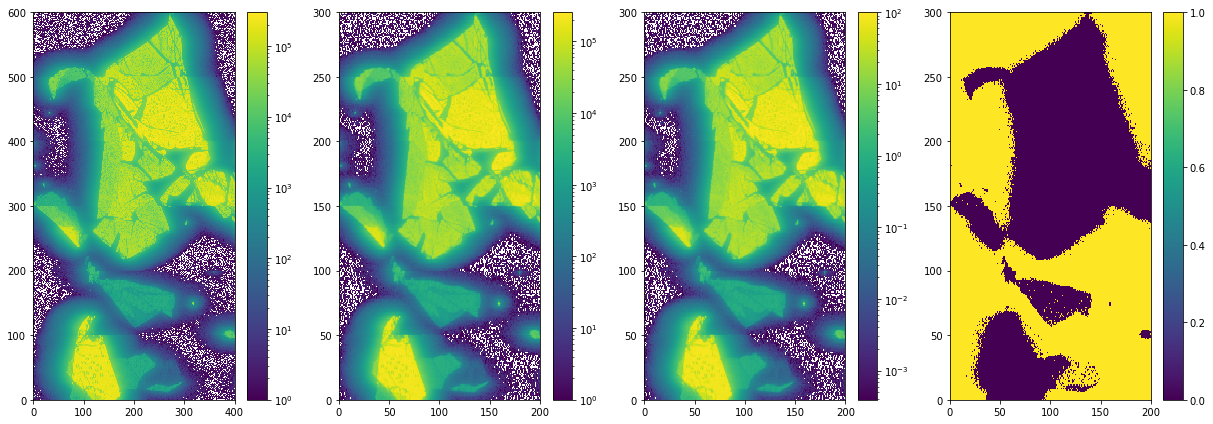

In [14]:
fig, axs = plt.subplots(1, 4, figsize=[17,6])
plt.subplot(1,4,1)
plt.pcolormesh(int1, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,2)
plt.pcolormesh(int_rescaled, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,3)
plt.pcolormesh(normalized_int, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,4)
plt.pcolormesh(xrf_threshold, cmap=cm)#, norm=cnorm())
plt.colorbar()
plt.tight_layout()

In [15]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.3
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [16]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=(300, 200),
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_combined)

In [17]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [18]:
run_sampling(sample, results=results, results_frequency_step=0, results_frequency_percentage=1, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

Reached the stopping ratio set in the sample parameters. Stopping scan.


(<sladsnet.code.results.Result at 0x1543db3a0>, 350)

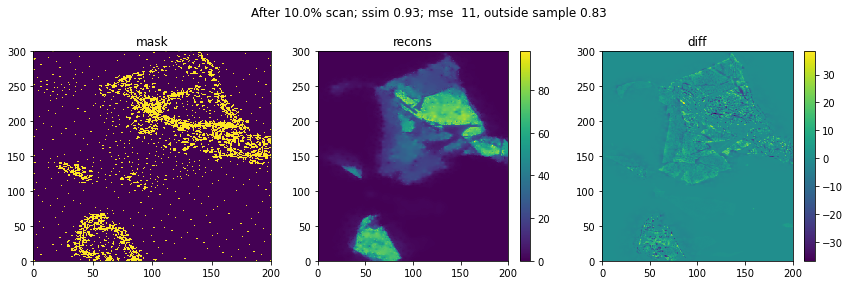

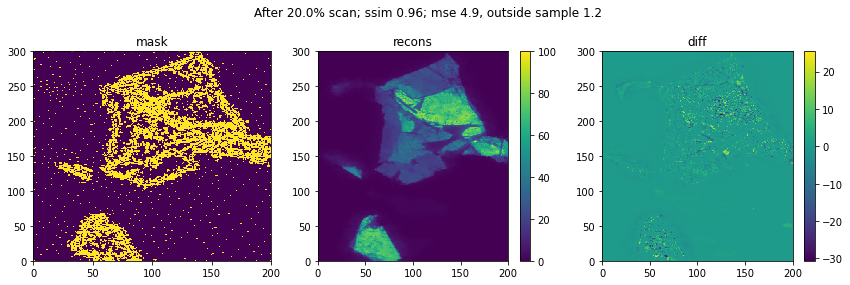

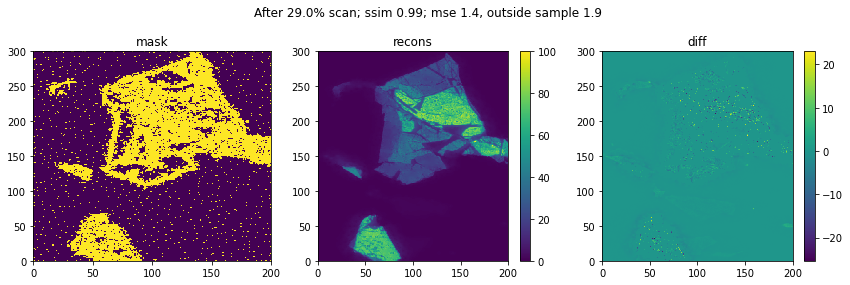

In [19]:
for i in range(3):
    scan_ratio = (i + 1) * 0.1
    percent = int(scan_ratio * 100)
    
    if percent >= results.size:
        percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[percent].sum() / results.outputs.masks[percent].size * 100, 0)
    percent_outside_sample = results.outputs.masks[percent][xrf_threshold].sum() / results.outputs.masks[percent].size * 100
    
    
    fig, axs = plt.subplots(1, 3, figsize=[12, 4])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[percent])
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[percent])
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[percent]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[percent])
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[percent], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[percent], measurement_interface.image)
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, outside sample {percent_outside_sample:3.2g}')
    plt.tight_layout()
    plt.show()


In [21]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

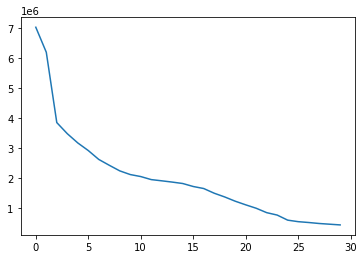

In [22]:
plt.plot(total_erds)

In [23]:
total_erds

array([7037139.  , 6204141.5 , 3861582.2 , 3492192.8 , 3183809.  ,
       2930262.  , 2633968.  , 2439701.  , 2253145.  , 2130294.  ,
       2063649.5 , 1962240.2 , 1921756.9 , 1879427.  , 1831971.  ,
       1732594.6 , 1664775.8 , 1508492.8 , 1384183.8 , 1242844.6 ,
       1121775.2 , 1007982.4 ,  861212.44,  780823.44,  611789.7 ,
        561064.4 ,  533044.2 ,  500202.94,  476523.3 ,  452801.62],
      dtype=float32)